# Goal 
The goal of this notebook is to investigate, using simulations, the effectiveness and usefuleness of the deconfounder approach to causal inference with latent confounding in recovering the true causal effects of variables. 

The flow of this notebook is as follows: 
- Simulate observations based on a confounded structure, where one variable confounds all but one of the other variables. 
- Simulate a continuous outcome based on a linear model, where we know the true causal effect of each variable. 
- Ommit the confounder from the dataframe, and attempt to recover it using factor models (PCA). 
- Check the recovered (substitute) confounder against the true confounder using scatter plots. 
- Re-estimate the outcome regression model, controlling for the substitute confounder instead of the true confounder, and compare the estimated coefficients on the other confounded variables against the ground truth

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
import pylogit
from collections import OrderedDict
import pylogit as cm
from functools import reduce
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import ceil

from IPython import display
import seaborn as sns

import tensorflow as tf
import numpy as np
import numpy.random as npr
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm

from tensorflow_probability import edward2 as ed
from sklearn.datasets import load_breast_cancer
from pandas.plotting import scatter_matrix
from scipy import sparse, stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)


import os
os.listdir('.')

['investigating_deconfounder.py',
 'Factor_Model_tuning.py',
 '.DS_Store',
 'investigating_deconfounder.ipynb',
 '.gitkeep',
 'Causal_Graph_Tim_Data.ipynb',
 'Factor_Model_tuning.ipynb',
 'spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv',
 '.ipynb_checkpoints']

## Specify the assumed causal graph of the data generation process

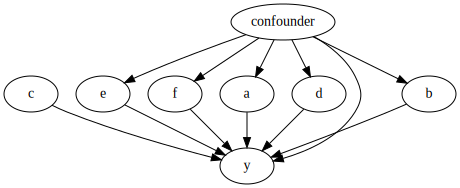

In [131]:
data_generation_graph = CausalGraphicalModel(
    nodes=['a', 'b', 'c', 'confounder',
          'd',  'e', 'f', 'y'],
    edges=[
        ("a", "y"), 
        ("b", "y"), 
        ("c", "y"), 
        ("d", "y"), 
        ("e", "y"), 
        ("f", "y"), 
        ("confounder", "y"), 
        
        
        ("confounder", "a"),
        ("confounder", "b"),
#         ("confounder", "c"),
        ("confounder", "d"),
        ("confounder", "e"),
        ("confounder", "f"),


        
        
#         ("confounder", "y"), 
#         ("confounder", "y"), 
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
data_generation_graph.draw()

## Specifiy the paramteric relationship between the covariates. 

In [249]:
sample_size = 10000

confounder = np.random.normal(loc=20, scale = 10, size = sample_size)

In [250]:
a = .3*confounder + np.random.normal(loc=10,scale=3,size=sample_size)
b = -1*confounder + np.random.normal(loc=6,scale=3,size=sample_size)
c = np.random.normal(loc=15,scale=3,size=sample_size) # + .5*confounder 
d = .8*confounder + np.random.normal(loc=-10,scale=3,size=sample_size)
e = .5*confounder + np.random.normal(loc=8,scale=3,size=sample_size)
f= -.3*confounder + np.random.normal(loc=-12,scale=3,size=sample_size)


df = pd.DataFrame(np.array([a,b,c,d,e,f, confounder]).T, columns = ['a', 'b', 'c',
          'd',  'e', 'f', 'confounder'])

X_columns =['a', 'b', 'c',
          'd',  'e', 'f', 'confounder']
df = (df[X_columns] - df[X_columns].mean())/df[X_columns].std()

# df['confounder'] = confounder - confounder.mean()/confounder.std()

y = 5 + 2*df['a'] + 2*df['b'] - 5*df['c'] + 3*df['d'] + 2*df['e'] - 5*df['f'] + 7*df['confounder'] + np.random.normal(loc=0,scale=1,size=sample_size)

df['y'] = y

# coeffs_true = [5,2,2,-5,3,2,-5,7]

# plt.hist(confounder, bins = 50)

# plt.hist(f, bins = 50)

In [251]:
# df = pd.DataFrame(np.array([a,b,c,d,e,f,confounder, y]).T, columns = ['a', 'b', 'c',
#           'd',  'e', 'f', 'confounder', 'y'])
df.head()

,a,b,c,d,e,f,confounder,y
0,-0.063863,0.472927,0.305876,-0.548896,0.683709,-0.032997,-0.181534,4.115042
1,0.037268,0.338675,-0.359341,0.032414,-0.238271,-0.008311,-0.503265,3.208012
2,1.454837,-0.177631,-0.347993,0.236172,0.632006,-1.059685,0.214385,18.651621
3,-1.156089,1.541955,-0.675919,-1.605075,-1.070602,2.152640,-1.933450,-19.745444
4,0.945168,0.304964,0.423880,0.446677,0.127459,0.843228,-0.105802,0.735621


In [252]:
# sns.pairplot(df, size=1.5)

## Bias from ommitting the confounder without adjustment

In [253]:
model_full = smf.ols("y ~ a+b+c+d+e+f + confounder", data=df)
results_full = model_full.fit()
results_df_full = pd.DataFrame(results_full.params, columns = ['estimated_params'])
results_df_full['std_errors'] = results_full.bse
results_df_full['true_params'] = coeffs_true
results_df_full

,estimated_params,std_errors,true_params
Intercept,5.003615,0.010006,5
a,1.990631,0.014253,2
b,2.022995,0.034774,2
c,-4.976860,0.010011,-5
d,3.009283,0.028461,3
e,1.996733,0.019394,2
f,-5.008048,0.014182,-5
confounder,7.018501,0.048992,7


In [254]:
model_partial = smf.ols("y ~ a+b+c+d+e+f ", data=df)
results_partial = model_partial.fit()
results_df_partial = pd.DataFrame(results_partial.params, columns = ['estimated_params'])
results_df_partial['std_errors'] = results_partial.bse
results_df_partial['true_params'] = coeffs_true[:-1]
results_df_partial

,estimated_params,std_errors,true_params
Intercept,5.003615,0.017485,5
a,2.394943,0.024413,2
b,-1.342894,0.044797,2
c,-4.981174,0.017495,-5
d,5.229357,0.041715,3
e,2.950037,0.031833,2
f,-5.459418,0.024164,-5


## Factor analysis: Is there evidence of latent factors?

In [255]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

In [256]:
chi_square_value,p_value=calculate_bartlett_sphericity(df[['a','b','c','d','e','f']])
print("Bartlett sphericity test indicates potential latent confounder, with a p-value of: ", p_value)

Bartlett sphericity test indicates potential latent confounder, with a p-value of:  0.0


In [257]:
# kmo_all,kmo_model=calculate_kmo(df[['a','b','c','d','e','f']])
# kmo_model

## Fitting a factor model using 3 PCA variations.



### Variable transformation

In [259]:
X_columns_red = ['a', 'b', 'c', 'd', 'e', 'f']

In [260]:
X = np.array(df[X_columns_red])

In [261]:
# X_columns = [
#     'a',
#        'b', 
#     'c',
#     'd',
#     'e',
#     'f'
#             ]


# X = np.array((df[X_columns] - df[X_columns].mean())/df[X_columns].std())


In [262]:
# standardized_df = pd.DataFrame(X, columns = ['a','b','c','d','e','f'])

# standardized_df['confounder'] = (df['confounder'] - df['confounder'].mean())/df['confounder'].std()

# standardized_df.head()

### estimate true coefficients on standardized variables

In [263]:
# model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder ", data=standardized_df)
# results_deconf = model_deconf.fit()
# results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
# results_df_deconf['std_errors'] = results_deconf.bse
# results_df_deconf['true_params'] = coeffs_true
# results_df_deconf

### Using sklearn

In [264]:
from sklearn.decomposition import PCA

In [265]:
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(X)

### Using the cross-validation: see function specified below

In [266]:
U, Vt, train_err, test_err, M, resid = cv_pca(data=X, rank=1)
train_err, test_err

(0.3522568590354147, 1.258923733362599)

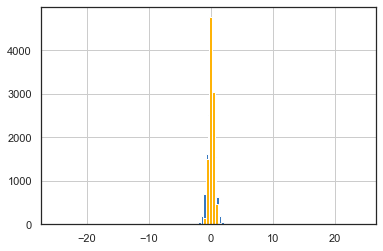

In [267]:
fig, ax = plt.subplots()
display.display(pd.Series(resid[:,0]).hist(bins=100))

# fig, ax = plt.subplots()
display.display(pd.Series(resid[:,1]).hist(bins=100))

### Using PPCA from Blei et. al's tutorial

Inferred axes:
[[ 0.80796325 -0.94216406  0.00871751  0.9259734   0.8854298  -0.7887358 ]]
Standard Deviation:
[[0.006679   0.00527384 0.00555152 0.00683648 0.00527241 0.00723634]]


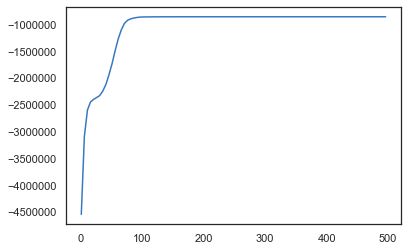

1

P-value, average:  [0.5403860505166476]


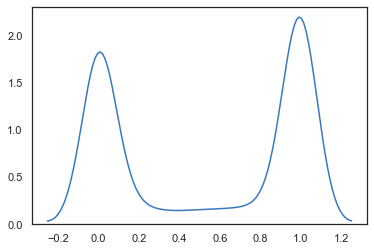

In [270]:
latent_dim = 1

confounders, holdouts, holdoutmasks, holdoutrow= confounder_ppca(holdout_portion=0.2, X=X, latent_dim=latent_dim)

holdouts_req = [holdouts]
display.display(len(holdouts_req))

confounder_req = [confounders]

n_rep = 100 # number of replicated datasets we generate
holdout_gen_util = []

for j in range(len(holdouts_req)):
    holdout_gen = np.zeros((n_rep,*(holdouts_req[j].shape)))
    
    for i in range(n_rep):
        w_sample = npr.normal(confounder_req[j][0], confounder_req[j][1])
        z_sample = npr.normal(confounder_req[j][2], confounder_req[j][3])
        
        data_dim_temp = holdouts_req[j].shape[1]
        latent_dim_temp = confounder_req[j][2].shape[1]
        num_datapoints_temp = holdouts_req[j].shape[0]
        
        with ed.interception(replace_latents(w_sample, z_sample)):
            generate = ppca_model(
                data_dim=data_dim_temp, latent_dim=latent_dim_temp,
                num_datapoints=num_datapoints_temp, stddv_datapoints=0.1, holdout_mask=holdoutmasks)

        with tf.Session() as sess:
            x_generated, _ = sess.run(generate)

        # look only at the heldout entries
        holdout_gen[i] = np.multiply(x_generated, holdoutmasks)
        
    holdout_gen_util.append(holdout_gen)
    
    
n_eval = 100 # we draw samples from the inferred Z and W
obs_ll_per_zi_per_mode = []
rep_ll_per_zi_per_mode = []
stddv_datapoints=0.1
for mode in range(len(holdouts_req)):
    obs_ll = []
    rep_ll = []

    for j in range(n_eval):
        w_sample = npr.normal(confounder_req[mode][0], confounder_req[mode][1])
        z_sample = npr.normal(confounder_req[mode][2], confounder_req[mode][3])

        holdoutmean_sample = np.multiply(z_sample.dot(w_sample), holdoutmasks)
        obs_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdouts_req[mode]), axis=1))

        rep_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdout_gen_util[mode]),axis=2))

    obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)
    obs_ll_per_zi_per_mode.append(obs_ll_per_zi)
    rep_ll_per_zi_per_mode.append(rep_ll_per_zi)

    
pval_mode = []
for mode in range(len(holdouts_req)):
    pvals = np.array([np.mean(rep_ll_per_zi_per_mode[mode][:,i] < obs_ll_per_zi_per_mode[mode][i]) 
                      for i in range(holdouts_req[mode].shape[0])])
    holdout_subjects = np.unique(holdoutrow)
    overall_pval = np.mean(pvals[holdout_subjects])
    pval_mode.append(overall_pval)
#     print("Predictive check p-values", overall_pval)

print("P-value, average: ", pval_mode)

display.display(sns.kdeplot(pvals[holdout_subjects]))

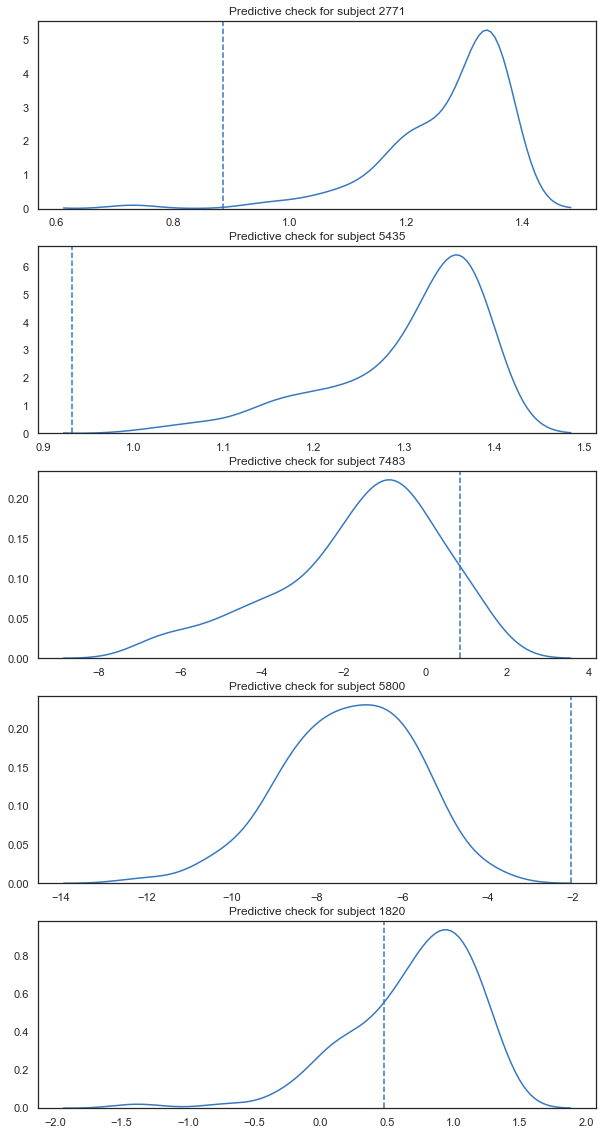

In [309]:
np.random.seed(11)

num_subjects = 5
fig, axes = plt.subplots(nrows = num_subjects, ncols=1, figsize = (10,20))

for i, ax in zip(range(num_subjects), axes.flat):
    subject_no = npr.choice(holdout_subjects) 
    sns.kdeplot(rep_ll_per_zi[:,subject_no], ax=ax).set_title("Predictive check for subject "+str(subject_no))
    ax.axvline(x=obs_ll_per_zi[subject_no], linestyle='--')

plt.show()

## Visualizing the substitute confounder against the true confounder

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


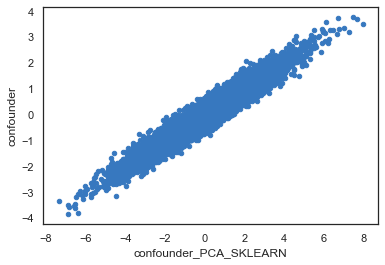

In [293]:
df.plot(kind='scatter', x = 'confounder_PCA_SKLEARN', y = 'confounder')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


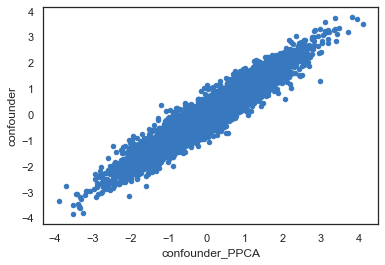

In [294]:
df.plot(kind='scatter', x = 'confounder_PPCA', y = 'confounder')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


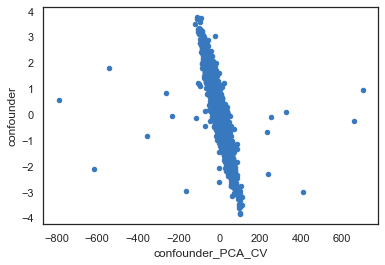

In [295]:
df.plot(kind='scatter', x = 'confounder_PCA_CV', y = 'confounder')

## Re-estimating regression with and without confounder

Notice I designed the simulation such that ommitting the confounder will flip the sign of the coefficient on $b$. When we add the confounder, estimated using any PCA variation, the coefficient on $b$ remains flipped. 

In [271]:
df['confounder_PCA_SKLEARN'] = principalComponents[:,0]

df['confounder_PCA_CV'] = U[:,0]

df['confounder_PPCA'] = confounders[2]

In [272]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true[:-1]
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,5.003615,0.017485,5
a,2.394943,0.024413,2
b,-1.342894,0.044797,2
c,-4.981174,0.017495,-5
d,5.229357,0.041715,3
e,2.950037,0.031833,2
f,-5.459418,0.024164,-5


In [273]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PCA_CV ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,5.003644,0.017485,5
a,2.388504,0.025199,2
b,-1.336499,0.045224,2
c,-4.982001,0.017513,-5
d,5.222295,0.042273,3
e,2.943428,0.032471,2
f,-5.452946,0.024965,-5
confounder_PCA_CV,-0.000988,0.000958,7


In [274]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PCA_SKLEARN ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,5.003615,0.017485,5
a,0.839111,0.024208,2
b,0.515690,0.044638,2
c,-4.989476,0.017495,-5
d,3.395381,0.041549,3
e,1.201186,0.031634,2
f,-3.918391,0.023960,-5
confounder_PCA_SKLEARN,3.830369,0.004491,7


In [275]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_PPCA ", data=df)
results_deconf = model_deconf.fit()
results_df_deconf = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf['std_errors'] = results_deconf.bse
results_df_deconf['true_params'] = coeffs_true
results_df_deconf

,estimated_params,std_errors,true_params
Intercept,5.003258,0.017481,5
a,2.330197,0.034994,2
b,-1.266551,0.053666,2
c,-4.981978,0.017493,-5
d,5.157270,0.050188,3
e,2.879609,0.041916,2
f,-5.394951,0.034743,-5
confounder_PPCA,0.304668,0.118009,7


## Adding random noise to the confounder and seeing how it affects the coefficients on the other variables

In [276]:
coef=0.5

df['confounder_2'] = df['confounder'] + coef*np.random.normal(loc=0,scale = 1, size = len(df))



In [281]:
model_deconf = smf.ols("y ~ a+b+c+d+e+f+confounder_2", data=df)
results_deconf = model_deconf.fit()
results_df_deconf1 = pd.DataFrame(results_deconf.params, columns = ['estimated_params'])
results_df_deconf1['std_errors'] = results_deconf.bse
results_df_deconf1['true_params'] = coeffs_true
results_df_deconf1

,estimated_params,std_errors,true_params
Intercept,4.998633,0.016621,5
a,2.336199,0.023276,2
b,-0.874132,0.044934,2
c,-4.979599,0.016630,-5
d,4.887101,0.041013,3
e,2.823868,0.030504,2
f,-5.393244,0.023058,-5
confounder_2,1.006159,0.030793,7


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


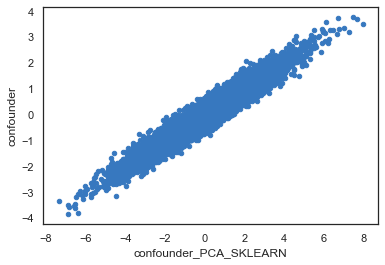

In [278]:
df.plot(kind='scatter', x = 'confounder_PCA_SKLEARN', y = 'confounder')

In [279]:
df[['confounder', 'confounder_PPCA']].corr()

,confounder,confounder_PPCA
confounder,1.000000,0.953869
confounder_PPCA,0.953869,1.000000


## Functions and fun stuff

In [177]:
def create_confounded_df(x, y, slope, groups):
    b = 0
    d = distance_line(b, slope, x, y)
    
    d_scaled = 0.0001 + .9999*(d-min(d))/(max(d)-min(d))
    
    df = pd.DataFrame()
    
    df['x'] = x
    df['y'] = y
    
    
    
    df['group'] = pd.Categorical(np.array([ceil(groups*(i)) for i in d_scaled]))
    
    return df
    
#     df['group'] = df['group'].astype('category')
     
    
def distance_line(b, m, x, y):
    return (y - (m*x + b))/np.sqrt(m**2 + 1)

test_df = create_confounded_df(x=a,y=y,slope=1, groups=100)

model = smf.ols("y ~ a + group", data=test_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.116e+05
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:23:25   Log-Likelihood:                -2023.7
No. Observations:               10000   AIC:                             4233.
Df Residuals:                    9907   BIC:                             4904.
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -58.9926      0.298   -198.145      0.000     -59.576     -58.409
group[T.2]       1.7098      0.365      4.691      0.000       0.995       2.424
group[T.3]       2.6367      0.365      7.232      0.000       1.922       3.351
group[T.4]       3.4722      0.421      8.249      0.000       2.647       4.297
group[T.5]       4.9901      0.365     13.689      0.000       4.276       5.705
group[T.6]       5.7582      0.333     17.304      0.000       5.106       6.411
group[T.7]       6.8917      0.344     20.053      0.000       6.218       7.565
group[T.8]       7.6182      0.321     23.697      0.000       6.988       8.248
group[T.9]       8.7936      0.321     27.353      0.000       8.163       9.424
group[T.10]     10.0570      0.333     30.223      0.000       9.405      10.709
group[T.11]     10.9365      0.312     35.035      0.000      10.325      11.548
group[T.12]     11.8368      0.326     36.305      0.000      11.198      12.476
group[T.13]     12.9912      0.307     42.261      0.000      12.389      13.594
group[T.14]     13.9566      0.309     45.186      0.000      13.351      14.562
group[T.15]     15.1360      0.314     48.244      0.000      14.521      15.751
group[T.16]     15.9224      0.312     51.006      0.000      15.310      16.534
group[T.17]     16.9766      0.304     55.930      0.000      16.382      17.572
group[T.18]     18.0715      0.306     59.006      0.000      17.471      18.672
group[T.19]     19.1417      0.304     63.062      0.000      18.547      19.737
group[T.20]     20.1563      0.302     66.746      0.000      19.564      20.748
group[T.21]     21.1285      0.301     70.175      0.000      20.538      21.719
group[T.22]     22.2611      0.301     73.851      0.000      21.670      22.852
group[T.23]     23.1890      0.301     77.155      0.000      22.600      23.778
group[T.24]     24.2492      0.300     80.801      0.000      23.661      24.837
group[T.25]     25.3254      0.300     84.517      0.000      24.738      25.913
group[T.26]     26.3381      0.299     88.035      0.000      25.752      26.925
group[T.27]     27.3225      0.299     91.316      0.000      26.736      27.909
group[T.28]     28.4274      0.299     95.086      0.000      27.841      29.013
group[T.29]     29.4442      0.299     98.501      0.000      28.858      30.030
group[T.30]     30.4530      0.299    101.912      0.000      29.867      31.039
group[T.31]     31.4799      0.299    105.420      0.000      30.895      32.065
group[T.32]     32.5446      0.299    108.942      0.000      31.959      33.130
group[T.33]     33.5812      0.299    112.424      0.000      32.996      34.167
group[T.34]     34.5806      0.299    115.817      0.000      33.995      35.166
group[T.35]     35.6176      0.298    119.363      0.000      35.033      36.203
group

In [178]:
import numpy as np
from numpy.random import randn, rand
from scipy.optimize import minimize
import matplotlib.pyplot as plt
# from nnls import nnlsm_blockpivot as nnlstsq
import itertools
from scipy.spatial.distance import cdist

def censored_lstsq(A, B, M):
    """Solves least squares problem with missing data in B
    Note: uses a broadcasted solve for speed.
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    Returns
    -------
    X (ndarray) : r x n matrix that minimizes norm(M*(AX - B))
    """

    if A.ndim == 1:
        A = A[:,None]

    # else solve via tensor representation
    rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    try:
        # transpose to get r x n
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T
    except:
        r = T.shape[1]
        T[:,np.arange(r),np.arange(r)] += 1e-6
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T



def cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=False, iterations = 1000):
    """Fit PCA while holding out a fraction of the dataset.
    """

#     # choose solver for alternating minimization
#     if nonneg:
#         solver = censored_nnlstsq
#     else:
    solver = censored_lstsq

    # create masking matrix
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout

    # initialize U randomly
    if nonneg:
        U = np.random.rand(data.shape[0], rank)
    else:
        U = np.random.randn(data.shape[0], rank)

    # fit pca/nmf
    for itr in range(iterations):
        Vt = solver(U, data, M)
        U = solver(Vt.T, data.T, M.T).T

    # return result and test/train error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
    return U, Vt, train_err, test_err, M, resid

In [268]:
def confounder_ppca(X, latent_dim, holdout_portion):
    # randomly holdout some entries of X
    num_datapoints, data_dim = X.shape

    holdout_portion = holdout_portion
    n_holdout = int(holdout_portion * num_datapoints * data_dim)

    holdout_row = np.random.randint(num_datapoints, size=n_holdout)
    holdout_col = np.random.randint(data_dim, size=n_holdout)
    holdout_mask = (sparse.coo_matrix((np.ones(n_holdout), \
                                (holdout_row, holdout_col)), \
                                shape = X.shape)).toarray()

    holdout_subjects = np.unique(holdout_row)

    x_train = np.multiply(1-holdout_mask, X)
    x_vad = np.multiply(holdout_mask, X)

    def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints):
        w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                    scale=tf.ones([latent_dim, data_dim]),
                    name="w")  # parameter
        z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                    scale=tf.ones([num_datapoints, latent_dim]), 
                    name="z")  # local latent variable / substitute confounder
        x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), 1-holdout_mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")  # (modeled) data
        return x, (w, z)

    log_joint = ed.make_log_joint_fn(ppca_model)

    latent_dim = latent_dim
    stddv_datapoints = 0.1

    model = ppca_model(data_dim=data_dim,
                       latent_dim=latent_dim,
                       num_datapoints=num_datapoints,
                       stddv_datapoints=stddv_datapoints)

    def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
        qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
        qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
        return qw, qz


    log_q = ed.make_log_joint_fn(variational_model)

    def target(w, z):
        """Unnormalized target density as a function of the parameters."""
        return log_joint(data_dim=data_dim,
                       latent_dim=latent_dim,
                       num_datapoints=num_datapoints,
                       stddv_datapoints=stddv_datapoints,
                       w=w, z=z, x=x_train)

    def target_q(qw, qz):
        return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
                   qz_mean=qz_mean, qz_stddv=qz_stddv,
                   qw=qw, qz=qz)


    qw_mean = tf.Variable(np.ones([latent_dim, data_dim]), dtype=tf.float32)
    qz_mean = tf.Variable(np.ones([num_datapoints, latent_dim]), dtype=tf.float32)
    qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
    qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([num_datapoints, latent_dim]), dtype=tf.float32))

    qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                               qz_mean=qz_mean, qz_stddv=qz_stddv)


    energy = target(qw, qz)
    entropy = -target_q(qw, qz)

    elbo = energy + entropy


    optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
    train = optimizer.minimize(-elbo)

    init = tf.global_variables_initializer()

    t = []

    num_epochs = 500

    with tf.Session() as sess:
        sess.run(init)

        for i in range(num_epochs):
            sess.run(train)
            if i % 5 == 0:
                t.append(sess.run([elbo]))

            w_mean_inferred = sess.run(qw_mean)
            w_stddv_inferred = sess.run(qw_stddv)
            z_mean_inferred = sess.run(qz_mean)
            z_stddv_inferred = sess.run(qz_stddv)

    print("Inferred axes:")
    print(w_mean_inferred)
    print("Standard Deviation:")
    print(w_stddv_inferred)

    plt.plot(range(1, num_epochs, 5), t)
    plt.show()

    def replace_latents(w, z):

        def interceptor(rv_constructor, *rv_args, **rv_kwargs):
            """Replaces the priors with actual values to generate samples from."""
            name = rv_kwargs.pop("name")
            if name == "w":
                rv_kwargs["value"] = w
            elif name == "z":
                rv_kwargs["value"] = z
            return rv_constructor(*rv_args, **rv_kwargs)

        return interceptor
    
    return [w_mean_inferred, w_stddv_inferred, z_mean_inferred, z_stddv_inferred], x_vad, holdout_mask, holdout_row

In [180]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints, holdout_mask):
    w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                scale=tf.ones([latent_dim, data_dim]),
                name="w")  # parameter
    z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                scale=tf.ones([num_datapoints, latent_dim]), 
                name="z")  # local latent variable / substitute confounder
    x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), 1-holdout_mask),
                scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                name="x")  # (modeled) data
    return x, (w, z)



def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
    qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
    qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
    return qw, qz



def target(w, z):
    """Unnormalized target density as a function of the parameters."""
    return log_joint(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints,
                   w=w, z=z, x=x_train)

def target_q(qw, qz):
    return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
               qz_mean=qz_mean, qz_stddv=qz_stddv,
               qw=qw, qz=qz)

def replace_latents(w, z):

    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replaces the priors with actual values to generate samples from."""
        name = rv_kwargs.pop("name")
        if name == "w":
            rv_kwargs["value"] = w
        elif name == "z":
            rv_kwargs["value"] = z
        return rv_constructor(*rv_args, **rv_kwargs)

    return interceptor